In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import time

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV

In [ ]:
import re
import random
import scipy.stats

In [4]:
import matplotlib.pyplot as plt
# ! pip install shap
import shap
shap.initjs()

In [ ]:
# import scipy.stats

# import matplotlib.pyplot as plt
# %matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.base import BaseEstimator, ClassifierMixin
# from sklearn.feature_selection import RFE, RFECV

In [6]:
# ! pip install catboost

In [7]:
# ! pip install scikit-optimize

In [ ]:
from sklearn.dummy import DummyClassifier, DummyRegressor

from sklearn.ensemble import RandomForestClassifier#, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet, SGDClassifier, SGDRegressor

from catboost import CatBoostClassifier, CatBoostRegressor, Pool, CatBoost
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

In [ ]:
# Bizzare problem: It seems that when you import one of lbgm, xgboost, Ridge, Lasso, ElasticNet, SGDClassifier, SGDRegressor, 
# if the below options are enabled, it will wreck any operation on a dataframe (including h df.head(), causing it to hang indefinitely

# pd.options.display.max_rows = None  # to stop pandas from not displaying all columns because of screen width
# pd.options.display.max_columns = None  # to stop pandas from not displaying all columns because of screen width
# pd.options.display.max_colwidth = 100  # To prevent pandas from concatenating very long columns. Set to 0.

# Load Data

In [10]:
sentencing_processed = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Sentencing_processed_data.csv",
                                  parse_dates=["DISPOSITION_DATE", "SENTENCE_DATE",
                                                 "INCIDENT_BEGIN_DATE", "INCIDENT_END_DATE",
                                                 "ARREST_DATE", "ARRAIGNMENT_DATE", "RECEIVED_DATE"],
                                  index_col=0)

Columns (8,9,12,15) have mixed types.Specify dtype option on import or set low_memory=False.


In [ ]:
sentencing = sentencing_processed.copy()

In [ ]:
# Time encoding for "ARREST_DATE"
sentencing["month"] = sentencing["ARREST_DATE"].apply(lambda x: x.month)

# sin/cos for seasonality
sentencing["month_sin"] = np.sin(2*np.pi*sentencing["month"]/12)
sentencing["month_cos"] = np.cos(2*np.pi*sentencing["month"]/12)

# linear encoding
min_date = min(sentencing["ARREST_DATE"])
sentencing["days_number"] = (sentencing["ARREST_DATE"] - min_date).dt.days

In [14]:
df_train_1, df_test_1 = train_test_split(sentencing, test_size=0.2, random_state=123)
print(len(df_test_1) / (len(df_test_1) + len(df_train_1)))

0.2


In [15]:
len(df_train_1)

184852

In [ ]:
y_train_type = df_train_1["categorical_sentence"]  # for categorical_sentence
y_train_length = df_train_1["sentence_period_years"]  # for sentence_period_years

y_test_type = df_test_1["categorical_sentence"]
y_test_length = df_test_1["sentence_period_years"]

# Preprocess Data for Model Input

In [ ]:
# categorize features for preprocessing

# includes all features that are an outcome of the judicial process and not the crime except for any features
# that are used to classify the crime (since I have no other way of knowing what the crime is). 
drop_features = ["CASE_ID", "CASE_PARTICIPANT_ID", "CHARGE_ID", "CHARGE_VERSION_ID", "LENGTH_OF_CASE_in_Days", "SENTENCE_PHASE",
                "SENTENCE_TYPE", "COMMITMENT_TYPE", "CURRENT_SENTENCE", "SENTENCE_JUDGE",
                "CHARGE_DISPOSITION_REASON", "COURT_NAME", "COURT_FACILITY", "RECEIVED_DATE",
                "DISPOSITION_DATE", "SENTENCE_DATE", "INCIDENT_BEGIN_DATE", "INCIDENT_END_DATE", "ARRAIGNMENT_DATE",
                "ARREST_DATE", "month", "DISPOSITION_CHARGED_AOIC"]
# drop length of case since this is information from after sentencing
# Drop sentence/commitment type since it has been merged into categorical_sentence
# CHARGE_DISPOSITION_REASON - too many missing features
# ARREST_DATE is dropped because we use the processed date features. month is a intermediary.

numeric_features = ["AGE_AT_INCIDENT", "month_sin", "month_cos", "days_number", "CHARGE_COUNT"]

# features to be one-hot encoded
categorical_features = ["OFFENSE_CATEGORY", "DISPOSITION_CHARGED_OFFENSE_TITLE", "CHARGE_DISPOSITION",
                        "GENDER", "RACE", "UPDATED_OFFENSE_CATEGORY",
                        "DISPOSITION_CHARGED_CHAPTER", "DISPOSITION_CHARGED_ACT", "DISPOSITION_CHARGED_SECTION",
                        "DISPOSITION_CHARGED_CLASS", "INCIDENT_CITY", "LAW_ENFORCEMENT_AGENCY", "UNIT",
                        "PRIMARY_CHARGE"] #use one-hot encoding with drop first
# UNIT is department of police force which is involved
# AOIC refers to Administrative Office of the Illinois Courts ID
# PRIMARY_CHARGE is boolean

# ordinal encoding
ordinal_features = []


# what we are predicting (y)
target_raw = ["COMMITMENT_TERM", "COMMITMENT_UNIT"] # raw target; will be dropped
target_processed = ["categorical_sentence", "sentence_period_years"]

drop_features = drop_features + target_raw + target_processed

In [ ]:
temp_a  = list(drop_features + numeric_features + categorical_features + ordinal_features)
temp_a.sort()

temp_b = list(sentencing.columns)
temp_b.sort()

assert (temp_a == temp_b), "Columns do not match"

In [19]:
# Drop target columns - skip if running again
# df_train = df_train.drop(columns=target_raw+target_processed, axis=1, errors='ignore')
# df_test = df_test.drop(columns=target_raw+target_processed, axis=1, errors='ignore')

df_train = df_train_1[numeric_features+categorical_features]
df_test = df_test_1[numeric_features+categorical_features]


df_train[numeric_features] = df_train[numeric_features].astype('float')  # ensure all numeric fields are float
# df_train["PRIMARY_CHARGE"] = df_train["PRIMARY_CHARGE"].astype(str)  # convert boolean to string
df_train[categorical_features] = df_train[categorical_features].astype(str)  # ensure no floats

df_test[numeric_features] = df_test[numeric_features].astype('float')
# df_test["PRIMARY_CHARGE"] = df_test["PRIMARY_CHARGE"].astype(str)
df_test[categorical_features] = df_test[categorical_features].astype(str)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Note: The code above will lead to missing data for predicting the sentence duration as you should know what kind of sentence is given.
# Ignoring for now, but this means that I should not predict duration without fixing this

In [ ]:
categorical_transformer_cat = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', missing_values=np.nan, fill_value='?')),
])

categorical_transformer_ohe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', missing_values=np.nan, fill_value='?')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [ ]:
numeric_transformer_cat = Pipeline([
    ('imputer', SimpleImputer(strategy='median', missing_values=np.nan)),
    ('scaler', StandardScaler())
])

numeric_transformer_ohe = Pipeline([
    ('imputer', SimpleImputer(strategy='median', missing_values=np.nan)),
    ('scaler', StandardScaler())
])

In [ ]:
preprocessor_cat = ColumnTransformer([
    ('numeric', numeric_transformer_cat, numeric_features),
    ('categorical', categorical_transformer_cat, categorical_features)
], remainder='drop')

preprocessor_ohe = ColumnTransformer([
    ('numeric', numeric_transformer_ohe, numeric_features),
    ('categorical', categorical_transformer_ohe, categorical_features)
], remainder='drop')

In [26]:
df_train.isna().sum()

AGE_AT_INCIDENT                      2383
month_sin                            3752
month_cos                            3752
days_number                          3752
CHARGE_COUNT                            0
OFFENSE_CATEGORY                        0
DISPOSITION_CHARGED_OFFENSE_TITLE       0
CHARGE_DISPOSITION                      0
GENDER                                  0
RACE                                    0
UPDATED_OFFENSE_CATEGORY                0
DISPOSITION_CHARGED_CHAPTER             0
DISPOSITION_CHARGED_ACT                 0
DISPOSITION_CHARGED_SECTION             0
DISPOSITION_CHARGED_CLASS               0
INCIDENT_CITY                           0
LAW_ENFORCEMENT_AGENCY                  0
UNIT                                    0
PRIMARY_CHARGE                          0
dtype: int64

In [ ]:
preprocessor_ohe.fit(df_train)

In [28]:
preprocessor_cat.fit(df_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('numeric',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                                                                verbose=0)),
                                                 ('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                       

In [ ]:
preprocessor_cat.fit(df_train)
preprocessor_ohe.fit(df_train)

ohe = preprocessor_ohe.named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names(categorical_features))

new_columns_cat = numeric_features + categorical_features
new_columns_ohe = numeric_features + ohe_feature_names

In [ ]:
X_train_cat = pd.DataFrame(preprocessor_cat.transform(df_train), index=df_train.index, columns=new_columns_cat)
X_test_cat  = pd.DataFrame(preprocessor_cat.transform(df_test), index=df_test.index,  columns=new_columns_cat)

X_train_ohe = pd.DataFrame(preprocessor_ohe.transform(df_train), index=df_train.index, columns=new_columns_ohe)
X_test_ohe  = pd.DataFrame(preprocessor_ohe.transform(df_test), index=df_test.index,  columns=new_columns_ohe)

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
# replace any [, ], < in feature name since XGBoost has problems with it
X_train_ohe.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_ohe.columns.values]
X_test_ohe.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_ohe.columns.values]

# replace special characters since LightBGM has problems otherwise - the code below causes issues with XGBoost because it creates non unique features
# X_train_ohe.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train_ohe.columns]
# X_test_ohe.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test_ohe.columns]

- Note that I am not removing DISPOSITION_CHARGED_OFFENSE_TITLE and UPDATED_OFFENSE_CATEGORY, both of which are open to interpretation and therefore depend on the judgement to some extent.
- Also leaving CHARGE_DISPOSITION. All cases in this dataset were convicted but the sentence might depend on whether the defendant plead guilty or not.


# Train and Run Models
Results:
- DummyClassifier - 0.58
- CatBoost - 0.69

The fairly modest improvement in test score might be explained by the information in each row not being enough to discern the true gravity of a crime.<br><br>
An example is UPDATED_OFFENSE_CATEGORY. Two cases might have the same value in
this feature but may be vastly differently.<br>
- For instance 'Burglary' may be tried as a misdemeanour (which usually has a prison sentence < 1 year) if it was in a warehouse, did not involve weapons and the value of goods stolen was low.<br>
- On the other hand, if a Burglary was carried out with weapons, while injuring innocent bystanders and had a large monetary value, then it will very likely be tried as a felony with a minimum of 1 year in prison.

In [ ]:
modelDC = DummyClassifier(strategy="most_frequent")

In [ ]:
# All of the non CatBoost models are disabled because they only run on CPU and
# are too slow (takes about 1 day). You can comment out these lines to run them
# but be sure to initially run on a sample of n=1000 or less. 

# modelLR = LogisticRegression(max_iter=1000)

In [ ]:
# modelXG = XGBClassifier()

In [ ]:
# modelLB = LGBMClassifier()

In [ ]:
# Note change task_type to 'CPU' if computer does not have an NVIDIA graphics card and CUDA installed.
# Note: running on CPU is about 400 times slower (and will take about a day).
modelCB = CatBoostClassifier(cat_features=categorical_features, task_type="GPU", verbose=1000)

Run Time with n=100
- LogisticRegression - 0.5s (1)
- XGBoost - 10s (20)
- CatBoost - 90s (180)


- Logistic regression n=10000 - 80s

In [43]:
n=len(X_train_cat) # full dataset
# Removing all except Catboost since they are too slow for running on the whole dataset.

print("DummyClassifier")
%timeit -n1 -r1 modelDC.fit(X_train_ohe.head(n), y_train_type.head(n))

# print("\nLogisticRegression")
# %timeit -n1 -r1 modelLR.fit(X_train_ohe.head(n), y_train_type.head(n))

# print("\nXGBoost")
# %timeit -n1 -r1 modelXG.fit(X_train_ohe.head(n), y_train_type.head(n))

print("\nCatBoost")
%timeit -n1 -r1 modelCB.fit(X_train_cat.head(n), y_train_type.head(n))


# Has problems with the feature names
# print("\nLightBGM")
# %timeit -n1 -r1 modelLB.fit(X_train_ohe.head(n), y_train_type.head(n))

DummyClassifier
1 loop, best of 1: 156 ms per loop

CatBoost
Learning rate set to 0.188242
0:	learn: 1.6173932	total: 32.6ms	remaining: 32.5s
999:	learn: 0.6428163	total: 20.3s	remaining: 0us
1 loop, best of 1: 25.7 s per loop


In [ ]:
# Print default catboost parameters
# modelCB.get_all_params()

In [51]:
print("DummyClassifier")
print(f"Train: {modelDC.score(X_train_ohe.head(n), y_train_type.head(n))}")
print(f"Test: {modelDC.score(X_test_ohe.head(n), y_test_type.head(n))}")

# print("\nLogisticRegression")
# print(f"Train: {modelLR.score(X_train_ohe.head(n), y_train_type.head(n))}")
# print(f"Test: {modelLR.score(X_test_ohe.head(n), y_test_type.head(n))}")

# print("\nXGBoost")
# print(f"Train: {modelXG.score(X_train_ohe.head(n), y_train_type.head(n))}")
# print(f"Test: {modelXG.score(X_test_ohe.head(n), y_test_type.head(n))}")

print("\nCatBoost")
print(f"Train: {modelCB.score(X_train_cat.head(n), y_train_type.head(n))}")
print(f"Test: {modelCB.score(X_test_cat.head(n), y_test_type.head(n))}")


# print("\LightBGM")
# print(f"Train: {modelLB.score(X_train_ohe.head(n), y_train_type.head(n))}")
# print(f"Test: {modelLB.score(X_test_ohe.head(n), y_test_type.head(n))}")

DummyClassifier
Train: 0.5798097937809708
Test: 0.580421093631662

CatBoost
Train: 0.7223941315214334
Test: 0.6939172959989613


# Shap Analysis of the Effect of Features on Sentence Type

## Importance of Feature in Determining Prediction
- From the bar chart below, the feature which most affects the outcome is UPDATED_OFFENSE_CATEGORY and OFFENSE_CATEGORY which is expected since this is what describes the crime.
- Days_number also seems to be important. This is the number of days from an arbitrary starting point to the date of the incident.
- AGE_AT_INCIDENT also seems to be an important factor in deciding the type of sentence.
- It is nice to see that RACE is not at the top of the features that determine the sentence type.

In [46]:
explainer = shap.TreeExplainer(modelCB)
shap_values = explainer.shap_values(X_train_cat)
# shap_values.shape
shap.initjs()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [52]:
# order was verified manually by looking at which column of predict_proba was the highest
class_labels = y_train_type.unique()
class_labels.sort()
class_labels

array(['Boot Camp', 'Conditional Discharge', 'Court Supervision',
       'Drug Court Probation', 'Drug School', 'Gang Probation',
       'Intensive Drug Probation Services',
       'Intensive Probation Services', 'Juvenile IDOC', 'Life', 'Prison',
       'Probation', 'Sex Offender Probation'], dtype=object)

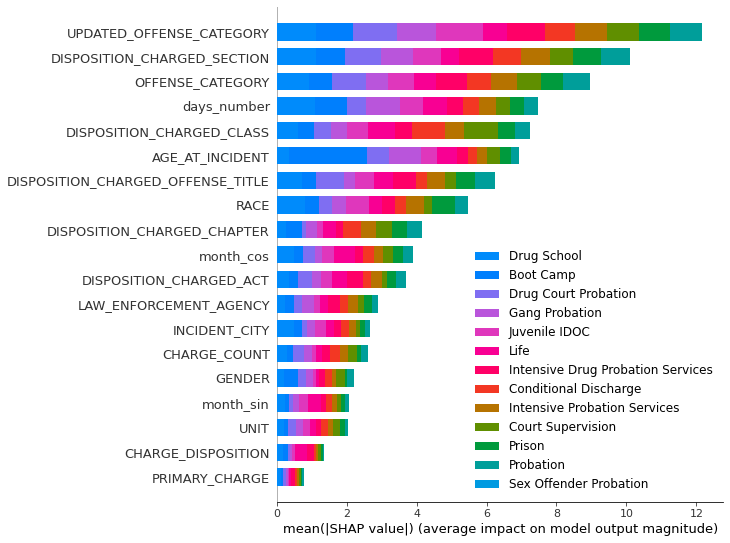

In [53]:
shap.summary_plot(shap_values, X_train_cat, class_names=class_labels)

## How Features Affect Likelihood of a Predicting a Given Class
Notes:
- The subplots at the top are the most important
- Only numeric features have colour in the subplot.
  - For numeric features, the x-axis shows whether the feature is more (to the right) or less (to the left) likely to be predicted (i.e. the predict_proba score for this feature).
- The only features that make sense in these plots are:
  - AGE_AT_INCIDENT
  - charge_count (number of other charges associated with a single trial. For example, a person would have 2 associated charges he commits burglary and in the process also manages to seriously injure someone else)

- Note: Ignore days_number (an integer value of the date of arrest from some starting date) and all of the other features.


<br>
Below, I have analyzed feature importance for 3 out of the 13 possible classes in the target (categorical_sentence).


For predicting bootcamp, the most important feature is AGE_AT_INCIDENT. Younger people are very rarely get a BootCamp sentence.


The effect of age on the likelihood of being sentenced to Life is not monotomic (there is no clear gradation from red to blue).<br>
Charge count very clearly affects probaility of getting Life sentences, with more charges making Life sentence more likely. 


Shap plot for prediction class - categorical_sentence=Life


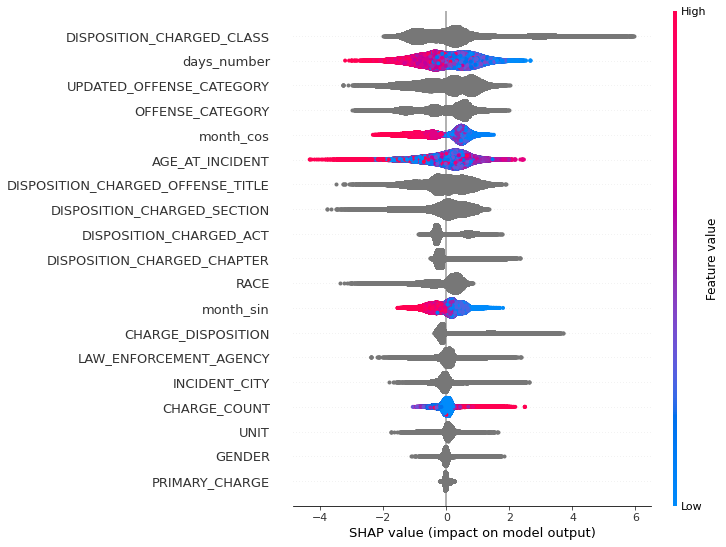

In [55]:
class_number = 9
print(f"Shap plot for prediction class - categorical_sentence={class_labels[class_number]}")
shap.summary_plot(shap_values[class_number], X_train_cat)

Age very strongly affects the likelihood of being sentenced to Drug Court Probation, with younger people being much more likely to be given this sentence.<br>
Also, from the charge count, it is clear that the more charges associated with a person, the less likely he is to be sentenced to Drug Court Probation (and therefore given a much more severe punishment).

Shap plot for prediction class - categorical_sentence=Drug Court Probation


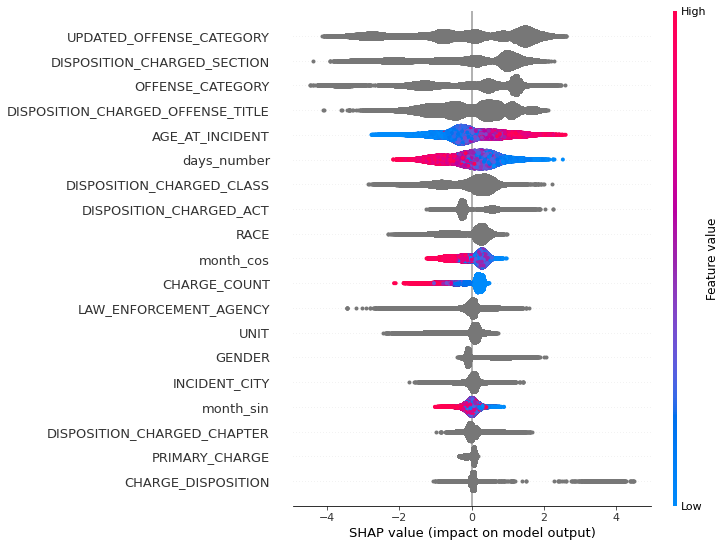

In [56]:
class_number = 3
print(f"Shap plot for prediction class - categorical_sentence={class_labels[class_number]}")
shap.summary_plot(shap_values[class_number], X_train_cat)

# Tuning Hyper-Parameters with RandomizedSearchCV
I tested this for CatBoost and it seems that it is not worth to optimize hyper paramers since CatBoost automatically selects very good hyper-paramers (this is a feature of CatBoost).<br>
Even running tens of folds with pparameters faily close to the values CatBoost selects, the best score was still slightly lower than for the automatic parameters.
<br>
Leaving the code below for reference.

https://effectiveml.com/using-grid-search-to-optimise-catboost-parameters.html<br>
CatBoost hyperparameters max reasonable range:
- n_estimators=[0,5000]
- learning_rate=[0.0001,1]
- l2_leaf_reg=[0,100]
- bootstrap_type=["Bayesian", "Bernoulli", "Poisson", "No"]
- one_hot_max_size=[1,255]
- max_depth=[1,16]
- random_strength=[0,500]
- border_count = [0,255]
- ctr_border_count = [0,255]

Recommended parameter space:<br>
https://github.com/talperetz/hyperspace/tree/master/GBDTs

Another good resource:<br>
https://towardsdatascience.com/https-medium-com-talperetz24-mastering-the-new-generation-of-gradient-boosting-db04062a7ea2

In [ ]:
# catboost_params_space = {
#     "n_estimators" : scipy.stats.randint(low=500, high=1500),  # too large takes too long to run
#     "learning_rate": [0.001, 0.01, 0.1, 1],
#     "l2_leaf_reg": scipy.stats.randint(low=1, high=100),
#     "bootstrap_type": ["Bernoulli", "No", "Poisson", "Bayesian"],
#     "one_hot_max_size": scipy.stats.randint(low=10, high=50),
#     "max_depth": scipy.stats.randint(low=1, high=11),  # too large takes too long to run
#     "random_strength": scipy.stats.randint(low=0, high=50),
#     "border_count": scipy.stats.randint(low=100, high=255),
# }

# Ran above configuration for 15 folds and it was worse than default parameters
# which means that catboost does a good job selecting default parameters.
# Trying to optimize only a few parameters that are known to be important.

catboost_params_space = {
    "n_estimators" : scipy.stats.randint(low=500, high=1500), # default=0.188242, too large takes too long to run
    "one_hot_max_size": scipy.stats.randint(low=2, high=20),  # default=2
    "max_depth": scipy.stats.randint(low=3, high=11),         # default=6 too, large takes too long to run
}

In [ ]:
# Randomized Search. Do not run in parallel if using CatBoost.
random_search = RandomizedSearchCV(modelCB, param_distributions = catboost_params_space, 
                                   n_iter = 5, cv=2, verbose=2,
                                   random_state=123, n_jobs=1)

In [ ]:
# Uncomment this code to run. Warning will take a long time even when running on GPU.

# n=len(X_train_cat)
# %timeit -n1 -r1 random_search.fit(X_train_cat.head(n), y_train_type.head(n));

# print(f"Best Parameters - {random_search.best_params_}")
# print(f"Best Score - {random_search.best_score_}")

# Appendix

In [ ]:
# Each crime may have multiple charges, so must ensure that two cases from the same crime do not end up in different tain/test splits
# because this will lead to data leaking to the test set.

# Note that during cross validation, I ignore this because it is too much trouble to do the splits properly, so the train scores will likely be inflated
# compared to the test scores, but since the test split is done correctly, the test score will be valid.

# Technically, I shouldn't need to do this if my understanding of how sentencing works (each case gets an independent sentence),
# but doing this to be on the safe side.

# sentencing_sorted = sentencing.sort_values(by=["CASE_ID"])
# random.seed(a=123, version=2)  # for reproduceability
# df_train = pd.DataFrame()
# df_test = pd.DataFrame()
# split_ratio = 0.2

# # estimated to take exactly 1 hour on 233k examples
# previous_id = 0
# last_set = 0; # "train" or "test"

# total_length = len(sentencing_sorted)

# for i in range(len(sentencing_sorted)):
#     if (i%100 == 0): print(i, time.time())
#     curr_line = sentencing_sorted.iloc[i]
#     if curr_line["CASE_ID"] == previous_id:
#         df_train.append(curr_line) if (last_set=="train") else df_test.append(curr_line)
#     else:
#         # sample random number to decide which dataset
#         if (random.random() < split_ratio):
#             last_set = "train"
#             df_train.append(curr_line)
#         else:
#             last_set = "test"
#             df_test.append(curr_line)
            
# print("Done split")

In [ ]:
# do nothing estimator; https://scikit-learn.org/stable/developers/develop.html
# Useful if you want to use remainder="drop" when building ColumnTransformer,
# but you still want to keep select features without processing them.
class Nothing(BaseEstimator, ClassifierMixin):

    def __init__(self, demo_param='demo'):
        self.demo_param = demo_param

    def fit(self, X, y):
        # Do nothing
        print()
        return self

    def predict(self, X):
        # Do nothing
        return None

    def transform(self, data):
        # return data without doing anything
        return data

passthrough_transformer = Pipeline([
    ('do_nothing', Nothing())
])

Something to try which might improve the model:
- Try dropping all rows for a given "CASE_ID" except for the row which had PRIMARY_CHARGE=True.